импорты

In [1]:
import os
import numpy as np
from natsort import natsorted
import matplotlib
import matplotlib.pyplot as plt
import re
import pandas as pd
from scipy import signal

константы

In [2]:
# 153.8336486816406250 884.2712384333286764    измеряемый диапазон. 0-2136 диапазон данных
start_nm = 400  # нм
end_nm = 700  # нм

x = pd.read_excel("x points nm.xlsx")
x = np.array(x["nm"].values[1 : len(x) - 1])


def nm_to_x(nm):
    return xint.index(nm) + 1


def x_to_nm(index):
    return x[index]


# номера точек в массиве по координате х
for i in range(len(x)):
    if x[i] > start_nm:
        start_x = i
        break
for i in range(len(x) - 1, 0, -1):
    if x[i] < end_nm:
        end_x = i
        break
x = x[start_x:end_x]
xint = list(np.array(x, dtype=int))
tail_x = nm_to_x(650)
head_x = nm_to_x(475)

функции получения данных

In [3]:
def get_data_rmr(path):
    """получение всей папки в виде списка с массивами np"""
    _file_list = np.array(natsorted(os.listdir(path)))
    _data = []
    for file in range(len(_file_list)):
        with open(path + _file_list[file], "r", encoding="utf8") as spec:
            spec = re.split(",", spec.read())
            _data.append(np.array(spec[start_x:end_x], dtype=float))
    #    _data.append(get_rmr(spec))
    return _data

получение данных из rmr. папка с папками

In [5]:
# получение всех спектров в виде списка в котором
# каждая строка - папка, а каждый элемент - массив np с спектром

data = []  # сглаженные графики
smooth = True
main_folder = r"C:\Users\Nik\Desktop\t"
main_folder = main_folder.replace(chr(92), "/")
folders_list = list(natsorted(os.listdir(main_folder)))
print(main_folder)
print(folders_list)

import concurrent.futures

data_row = [0] * len(folders_list)  # изанчальные графики


def func(fl):
    _ind = folders_list.index(fl)
    data_row[_ind] = get_data_rmr(main_folder + "/" + fl + "/")
    print(fl, " ", _ind + 1, " recived ", len(data_row[_ind]))


with concurrent.futures.ThreadPoolExecutor() as executor:
    executor.map(func, folders_list)


if smooth == True:
    for i in range(len(data_row)):
        d = []
        for j in range(len(data_row[i])):
            d.append(signal.savgol_filter(data_row[i][j], 60, 3))
        data.append(d)
else:
    data = data_row.copy()
print("получено " + str(len(data_row)) + " папок")

C:/Users/Nik/Desktop/t
['bad', 'good']
bad   1  recived  4000
good   2  recived  4300


KeyboardInterrupt: 

добавить 1 папку

In [4]:
data = []
data_row = []
folders_list = []

In [5]:
# получение всех спектров в виде списка в котором
# каждая строка - папка, а каждый элемент - массив np с спектром
smooth = True
main_folder = r"D:\Data\скр2\points\p4\4_2"
main_folder = main_folder.replace(chr(92), "/")
folders_list = np.append(folders_list, "spec 3_12")
print(main_folder)
print(folders_list)


data_row.append(get_data_rmr(main_folder + "/"))
# print("data from " + str(folders_list[i]) + " recived")
print("получено " + str(len(data_row)) + " папок")

if smooth == True:
    for i in range(len(data_row)):
        d = []
        for j in range(len(data_row[i])):
            d.append(signal.savgol_filter(data_row[i][j], 60, 3))
        data.append(d)
else:
    data = data_row.copy()

D:/Data/скр2/points/p4/4_2
['spec 3_12']
получено 1 папок


выборка лучших спектров

In [6]:
def data_for_hist(mas, ind):
    ar = np.zeros(len(mas))
    if ind == "max":
        for i in range(len(mas)):
            ar[i] = np.max(mas[i][nm_to_x(520) : nm_to_x(600)])
    else:
        for i in range(len(mas)):
            ar[i] = mas[i][ind]
    return ar


print_graf = False
fol = "aa"
data_new = []
gap = 0.02
for n in range(len(folders_list)):
    masiv = data[n]
    massiv_row = data_row[n]
    _d = []
    ar_max = data_for_hist(masiv, "max")
    ar_mean = data_for_hist(masiv, nm_to_x(650))
    ar_max_mean = ar_max - ar_mean

    maximum = np.max(ar_max_mean)
    ar = []  # индексы спектров с наибольшей разницей между мах и 650

    num_bins = 20  # количество интервалов
    range_values = (maximum / 2) / num_bins
    # границы интервалов
    bin_edges = np.arange(maximum / 2, maximum, range_values)
    # середины интервалов
    bins = bin_edges[:-1] + range_values / 2
    hist, _ = np.histogram(ar_max_mean, bins=bin_edges)
    zero = bin_edges[np.argmax(hist) + 1]
    if print_graf == True:
        fig, ax = plt.subplots(figsize=(5, 5), dpi=300)
        plt.ioff()
        ax.hist(
            ar_max_mean, bin_edges, alpha=0.6, color="blue", edgecolor="k", linewidth=1
        )

        ax.scatter(
            bin_edges[np.argmax(hist[5:20])] + 5.5 * range_values,
            np.max(hist[5:20]),
            color="red",
        )

        ax.plot(bins, hist, color="red", lw=2)
        plt.title("I(max)-I(650) histogram of" + str(folders_list[n]))
        plt.ylabel("Count, a.u.")
        plt.xlabel("Intensity, a.u.")
        plt.xticks(rotation=90)
        ax.set_xticks(bin_edges)

        plt.tight_layout()

        plt.savefig(fol + "/" + folders_list[n] + ".png")
    maximum = bin_edges[np.argmax(hist[5:20])] + 5.5 * range_values
    for i in range(len(ar_max_mean)):
        if maximum - range_values < ar_max_mean[i] < maximum + range_values:
            ar.append(i)
    # if len(ar) == 0:
    # continue
    ar2 = []  # значения интенсивнотей в точке max
    for i in range(len(ar)):
        ar2.append(np.max(masiv[ar[i]]))
    minimum = np.min(ar2)

    ar3 = []  # индексы более подходящих спектров
    for i in range(len(ar)):
        if np.max(masiv[ar[i]]) < minimum + gap:
            ar3.append(ar[i])
    for i in range(len(ar3)):
        _d.append(massiv_row[ar3[i]])
    data_new.append(_d)

конечная выборка

In [7]:
spec = []  # сглаженный
spec_row = []  # не сглаженный


for i in range(len(data_new)):
    _a = len(data_new[i])

    _b = np.sum(data_new[i], axis=0)

    _b /= _a

    spec.append(signal.savgol_filter(_b, 100, 3))
    spec_row.append(_b)

построение лучших спектров

In [ ]:
import matplotlib as mpl

In [15]:
for n in range(len(spec)):
    plt.figure(figsize=(5, 5), dpi=300)

    plt.ioff()
    for i in range(len(data[n])):
        if x_to_nm(np.argmax(data[n][i])) > 520:
            plt.plot(
                x,
                data[n][i],
                lw=0.1,
                alpha=0.8,
                color="black",
            )
        else:
            plt.plot(
                x,
                data[n][i],
                lw=0.1,
                alpha=0.8,
                color="tab:Green",
            )
    for i in range(len(data_new[n])):
        plt.plot(
            x,
            signal.savgol_filter(data_new[n][i], 60, 3),
            lw=0.03,
            alpha=0.5,
            color="blue",
        )
    plt.plot(x, spec[n], color="red")
    plt.title(
        folders_list[n]
        + ", "
        + str(round(len(data_new[n]) * 100 / len(data[n]), 2))
        + "%"
    )
    plt.scatter(1, 1, color="tab:Green", label="Oil spectra")
    plt.scatter(1, 1, color="black", label="Reagent spectra")
    plt.scatter(1, 1, color="tab:blue", label="Selected spectra")
    plt.scatter(1, 1, color="tab:red", label="Average spectrum")

    plt.ylim(-0.01, 1.3 * np.max(spec[n]))
    plt.xlim(400, 700)
    plt.xlabel("Wavelenght, nm")
    plt.ylabel("Absorbance, a.u.")
    plt.title(
        str(len(data[n])) + " spectra of " + str(folders_list[n]) + " droplet series"
    )
    plt.legend(loc="lower left")
    plt.tight_layout()
    plt.savefig("AAAAAAAAA.png")
    # matplotlib.pyplot.close(figure)

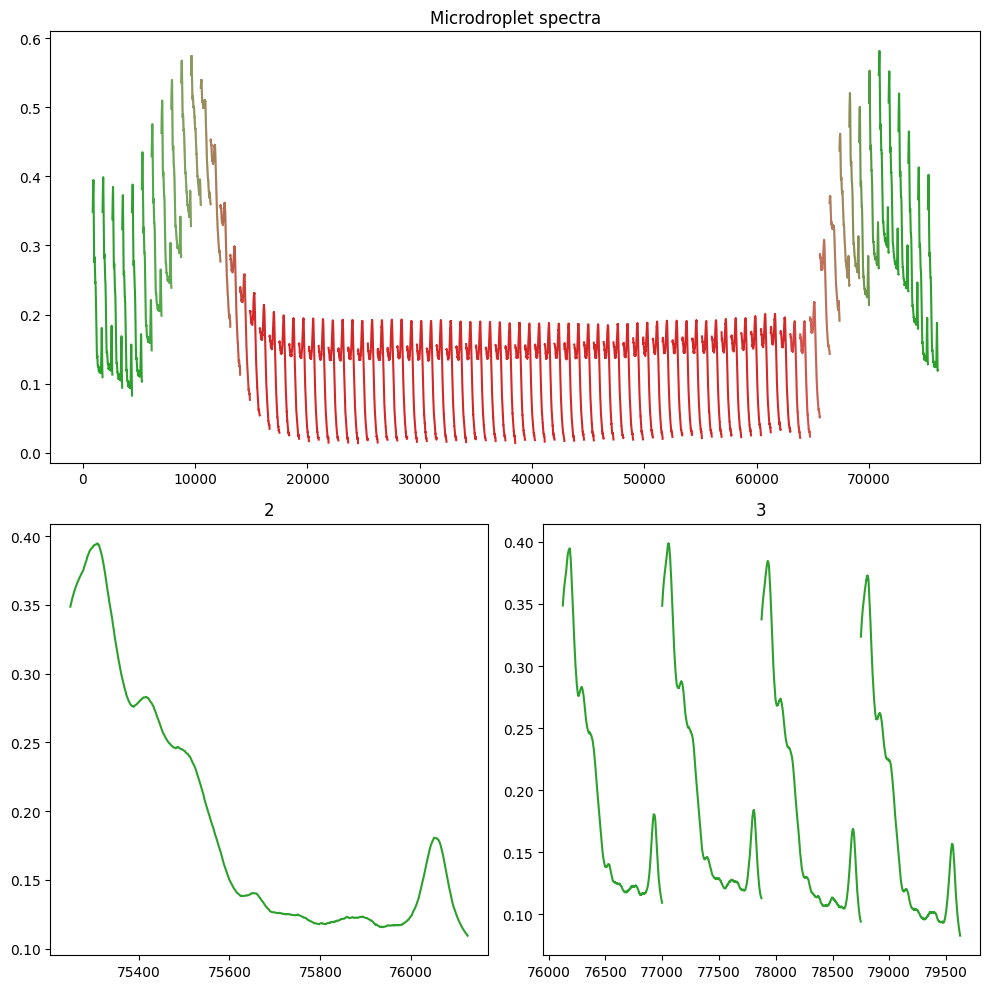

In [19]:
dx = np.arange(len(data[0][0]))
plt.figure(figsize=(10, 10), dpi=100)
mas = data[0][366:452]
# fig= plt.subplots(figsize=(9, 5), dpi=150)
ax1 = plt.subplot(211)
a = 1 / 12
aa = 0
for i in range(0, 4):
    dx += len(mas[0])
    ax1.plot(dx, mas[i], c="tab:green", alpha=1)
for i in range(4, 16):
    dx += len(mas[0])
    ax1.plot(dx, mas[i], c="tab:red", alpha=aa)
    ax1.plot(dx, mas[i], c="tab:green", alpha=1 - aa)
    aa += a
    # plt.scatter(i,np.max(data[0][i]))
for i in range(16, 70):
    dx += len(mas[0])
    ax1.plot(dx, mas[i], c="tab:red", alpha=1)
aa = 0
a = 0.1
for i in range(70, 80):
    dx += len(mas[0])
    ax1.plot(dx, mas[i], c="tab:green", alpha=aa)
    ax1.plot(dx, mas[i], c="tab:red", alpha=1 - aa)
    aa += a
for i in range(80, 86):
    dx += len(mas[0])
    ax1.plot(dx, mas[i], c="tab:green", alpha=1)

ax2 = plt.subplot(223)
ax2.plot(dx, mas[0], c="tab:green", alpha=1)

ax3 = plt.subplot(224)
a = 1 / 12
aa = 0

for i in range(0, 4):
    dx += len(mas[0])
    ax3.plot(dx, mas[i], c="tab:green", alpha=1)

ax1.set_title("Microdroplet spectra")
ax2.set_title("2")
ax3.set_title("3")

plt.tight_layout()

plt.savefig("aaa.svg")

получение смапа

In [ ]:
cmap = matplotlib.colormaps.get("Set1")(np.linspace(0, 1, len(spec)))

дескрипторы

In [ ]:
def coef_parabola(sp):
    """коэффициенты параболы"""
    _m = np.max(sp)
    _gap = 0.005
    _i = np.argmax(sp)
    if _i == 0 or _i + 300 > len(sp):
        return [0]
    _p, _q = 0, 0
    for i in range(_i, _i + 300):
        if sp[i] < _m - _gap:
            _q = i
            break
    for i in range(_i, _i - 300, -1):
        if sp[i] < _m - _gap:
            _p = i

            break
    try:
        _coefs = np.polyfit(
            x[_p:_q], sp[_p:_q], 2
        )  # Вторым аргументом передается степень полинома
    except:
        return [0]
    return _coefs


def w_h_75(sp):
    """ширина, высота"""
    _h = np.max(sp) - (np.max(sp) - sp[nm_to_x(450)]) * 0.25
    _start, _end = 0, 0
    _ind_max = np.argmax(sp)
    if _ind_max == 0 or _ind_max + 300 > len(sp):
        return [0, 0]
    for i in range(_ind_max, _ind_max + 300):
        if sp[i] <= _h:
            _end = i
            break
    for i in range(_ind_max, _ind_max - 300, -1):
        if sp[i] <= _h:
            _start = i
            break
    _w = x_to_nm(_end) - x_to_nm(_start)
    return (_w, _h, x_to_nm(_start), x_to_nm(_end))


def w_h_50(sp):
    """ширина, высота"""
    _h = np.max(sp) - (np.max(sp) - sp[nm_to_x(450)]) * 0.5
    _start, _end = 0, 0
    _ind_max = np.argmax(sp)
    if _ind_max == 0 or _ind_max + 300 > len(sp):
        return [0, 0]
    for i in range(_ind_max, _ind_max + 300):
        if sp[i] <= _h:
            _end = i
            break
    for i in range(_ind_max, _ind_max - 300, -1):
        if sp[i] <= _h:
            _start = i
            break
    _w = x_to_nm(_end) - x_to_nm(_start)
    return (_w, _h, x_to_nm(_start), x_to_nm(_end))


def angle_old(sp, point):
    _x1 = x_to_nm(np.argmax(sp))
    _y1 = np.max(sp)
    _x2 = point
    _y2 = sp[nm_to_x(point)]
    return ((_y2 - _y1) / (_x2 - _x1), _x1, _x2, _y1, _y2)


def angle(sp, point):
    _w = (650 - x_to_nm(np.argmax(sp))) / 4
    _x1 = x_to_nm(np.argmax(sp)) + _w
    _y1 = sp[nm_to_x(round(_x1))]
    _x2 = point
    _y2 = sp[nm_to_x(round(_x2))]
    return ((_y2 - _y1) / (_x2 - _x1), _x1, _x2, _y1, _y2)

In [ ]:
# выбор максимума
S_name = pd.Series(folders_list)
S_Imax = pd.Series(name="I(max)")
S_NMmax = pd.Series(name="I nm")
S_I650 = pd.Series(name="I(650)")
S_Imax_m_I650 = pd.Series(name="I(max) - I(650)")
S_Imax_d_I650 = pd.Series(name="I(max) d I(650)")
S_I400 = pd.Series(name="I(450)")
S_Imax_m_I400 = pd.Series(name="I(max) - I(450)")
S_Imax_d_I400 = pd.Series(name="I(max) d I(450)")
S_I400_d_I650 = pd.Series(name="I(400) d I(650)")
S_coef_a = pd.Series(name="coef A")
S_height75 = pd.Series(name="height75")
S_weight75 = pd.Series(name="weight75")
S_height50 = pd.Series(name="height50")
S_weight50 = pd.Series(name="weight50")
S_angle = pd.Series(name="ang")
_sp = nm_to_x(450)
for i in range(len(spec)):
    S_Imax.loc[i] = np.max(spec[i])
    S_NMmax.loc[i] = x[np.argmax(spec[i])]
    S_I650.loc[i] = spec[i][tail_x]
    S_Imax_m_I650.loc[i] = S_Imax.loc[i] - S_I650.loc[i]
    S_Imax_d_I650.loc[i] = S_Imax.loc[i] / S_I650.loc[i]
    S_I400.loc[i] = spec[i][_sp]
    S_Imax_m_I400.loc[i] = S_Imax.loc[i] - S_I400.loc[i]
    S_Imax_d_I400.loc[i] = S_Imax.loc[i] / S_I400.loc[i]
    S_I400_d_I650.loc[i] = S_I400.loc[i] / S_I650.loc[i]
    S_coef_a.loc[i] = coef_parabola(spec[i])[0]
    _w_h = w_h_75(spec[i])
    S_height75.loc[i] = _w_h[1]
    S_weight75.loc[i] = _w_h[0]
    _w_h = w_h_50(spec[i])
    S_height50.loc[i] = _w_h[1]
    S_weight50.loc[i] = _w_h[0]
    S_angle.loc[i] = angle(spec[i], 600)[0]

In [ ]:
for n in range(len(spec)):
    plt.figure(figsize=(10, 6))
    plt.ioff()
    plt.title(folders_list[n])
    # спектр
    plt.plot(x, spec[n], c="black")
    # максимум
    plt.scatter(S_NMmax[n], S_Imax[n], c="red", label="I(max) nm: " + str(S_NMmax[n]))
    plt.scatter(
        S_NMmax[n], S_Imax[n], c="red", label="I(max) : " + str(round(S_Imax[n], 5))
    )
    # 450
    plt.scatter(
        450,
        S_I400[n],
        c="blue",
        label="I(450) : "
        + str(round(S_I400[n], 5))
        + "\n"
        + "I(max) - I(450) : "
        + str(round(S_Imax_m_I400[n], 5))
        + "\n"
        + "I(max) d I(450) : "
        + str(round(S_Imax_d_I400[n], 5)),
    )
    # 650
    plt.scatter(
        650,
        S_I650[n],
        c="green",
        label="I(650) : "
        + str(round(S_I650[n], 5))
        + "\n"
        + "I(max) - I(650) : "
        + str(round(S_Imax_m_I650[n], 5))
        + "\n"
        + "I(max) d I(650) : "
        + str(round(S_Imax_d_I650[n], 5)),
    )
    # парабола
    coef = coef_parabola(spec[n])
    x1 = np.linspace(S_NMmax[n] - 15, S_NMmax[n] + 15, 100)
    plt.plot(
        x1,
        coef[0] * x1**2 + coef[1] * x1 + coef[2],
        alpha=0.9,
        c="crimson",
        label="coef a : " + str(round(coef[0], 8)),
    )
    # ширина на 75%высоты
    plt.plot(
        (w_h_75(spec[n])[2], w_h_75(spec[n])[3]),
        (S_height75[n], S_height75[n]),
        c="seagreen",
        label="weight75 : " + str(round(S_weight75[n], 3)),
    )
    # высота на 75%высоты
    plt.plot(
        (w_h_75(spec[n])[2], w_h_75(spec[n])[2]),
        (0, S_height75[n]),
        c="mediumblue",
        label="height75 : " + str(round(S_height75[n], 5)),
    )
    # ширина на 75%высоты
    plt.plot(
        (w_h_50(spec[n])[2], w_h_50(spec[n])[3]),
        (S_height50[n], S_height50[n]),
        c="springgreen",
        label="weight50 : " + str(round(S_weight50[n], 3)),
    )
    # высота на 75%высоты
    plt.plot(
        (w_h_50(spec[n])[2], w_h_50(spec[n])[2]),
        (0, S_height50[n]),
        c="purple",
        label="height50 : " + str(round(S_height50[n], 5)),
    )
    ang = angle(spec[n], 600)
    plt.plot(
        (ang[1], ang[2]),
        (ang[3], ang[4]),
        c="orange",
        label="angle : " + str(round(ang[0], 7)),
    )
    plt.legend(loc="upper right")
    plt.savefig("des/" + str(folders_list[n]) + ".png")

построение карт

In [ ]:
import sys

sys.path.append(r"C:\Users\Nik\Desktop\prog")
from pyfitit import *

In [ ]:
data_measure = pd.concat(
    [
        S_Imax,
        S_NMmax,
        S_I650,
        S_Imax_m_I650,
        S_Imax_d_I650,
        S_I400,
        S_Imax_m_I400,
        S_Imax_d_I400,
        S_coef_a,
        S_height75,
        S_weight75,
        S_height50,
        S_weight50,
        S_angle,
    ],
    axis=1,
)
data_measure.to_excel("output 4.2.xlsx", index=False)

In [ ]:
data_speed = pd.read_excel("s1.xlsx")
data_measure = pd.concat(
    [
        S_Imax,
        S_NMmax,
        S_I650,
        S_Imax_m_I650,
        S_Imax_d_I650,
        S_I400,
        S_Imax_m_I400,
        S_Imax_d_I400,
        S_coef_a,
        S_height75,
        S_weight75,
        S_height50,
        S_weight50,
        S_angle,
    ],
    axis=1,
)
data_table = pd.concat([data_speed, data_measure], axis=1)
print(data_table.columns[0:])

In [ ]:
data_table.to_excel("output 1.xlsx", index=False)